In [1]:
#This code heavily references code =used for the following tutorial article:
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)


Bad key "text.kerning_factor" on line 4 in
C:\Users\mnewk\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dataset = pd.read_csv('data/BTC_Signals.csv')

In [3]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Circulating Supply,Max Supply,Supply Ratio,Volume Supply Ratio,Volume Close Ratio,nupl_ratio,mvrv_ratio,SMA50_close,SMA100_close,SMA50_supply,SMA100_suppy,bollinger_mid_band_close,bollinger_std_close,bollinger_mid_band_supply,bollinger_std_supply,bollinger_upper_band_close,bollinger_lower_band_close,fast_close,slow_close,fast_supply,slow_supply,crossover_long_close,crossover_short_close,crossover_signal_close,crossover_long_supply,crossover_short_supply,crossover_signal_supply,mvrv_signal,nupl_signal
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,13280850.0,21000000.0,63.242143,1.585501,46042.496970,0.215017,0.446781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457.334015,457.334015,63.242143,63.242143,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,13280850.0,21000000.0,63.242143,2.596460,81243.991701,0.170461,0.330261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.479942,440.683444,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,13280850.0,21000000.0,63.242143,2.855216,96048.847913,0.110795,0.196148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.492103,425.007451,63.242143,63.242143,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,13292775.0,21000000.0,63.298929,2.773206,90152.213530,0.143593,0.275693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.301065,420.830884,63.257410,63.256871,0.0,-1.0,-1.0,1.0,0.0,1.0,0,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,13292775.0,21000000.0,63.298929,1.999590,66646.688783,0.122571,0.222286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.569492,416.208314,63.266556,63.265704,0.0,-1.0,-1.0,1.0,0.0,1.0,0,0


In [4]:
dataset.shape

(2375, 36)

In [5]:
data = dataset[['Close','Volume','Circulating Supply','Supply Ratio','Volume Supply Ratio']].copy()

In [6]:
data.head()

,Close,Volume,Circulating Supply,Supply Ratio,Volume Supply Ratio
0,457.334015,21056800.0,13280850.0,63.242143,1.585501
1,424.440002,34483200.0,13280850.0,63.242143,2.596460
2,394.795990,37919700.0,13280850.0,63.242143,2.855216
3,408.903992,36863600.0,13292775.0,63.298929,2.773206
4,398.821014,26580100.0,13292775.0,63.298929,1.999590


In [7]:
data.shape

(2375, 5)

In [8]:
# convert series to supervised learning
###https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
values = data.values

In [10]:
values = values.astype('float32')

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [12]:
reframed = series_to_supervised(scaled, 1, 1)

In [13]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.004598   0.000043    0.00000    0.00000   0.000061  0.004056  0.000081   
2   0.004056   0.000081    0.00000    0.00000   0.000114  0.003568  0.000091   
3   0.003568   0.000091    0.00000    0.00000   0.000128  0.003800  0.000088   
4   0.003800   0.000088    0.00222    0.00222   0.000124  0.003634  0.000059   
5   0.003634   0.000059    0.00222    0.00222   0.000083  0.003689  0.000052   

   var3(t)  var4(t)   var5(t)  
1  0.00000  0.00000  0.000114  
2  0.00000  0.00000  0.000128  
3  0.00222  0.00222  0.000124  
4  0.00222  0.00222  0.000083  
5  0.00222  0.00222  0.000073  


In [14]:
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True) #4,8,12,16,20
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.004598   0.000043    0.00000    0.00000   0.000061  0.004056
2   0.004056   0.000081    0.00000    0.00000   0.000114  0.003568
3   0.003568   0.000091    0.00000    0.00000   0.000128  0.003800
4   0.003800   0.000088    0.00222    0.00222   0.000124  0.003634
5   0.003634   0.000059    0.00222    0.00222   0.000083  0.003689


In [15]:
values = reframed.values

In [16]:
split = int(0.7 * len(values))
train = values[:split,:]
test = values[split:,:]
n_features = 5
n_steps = 1

In [17]:
train.shape

(1653, 6)

In [18]:
train.shape

(1653, 6)

In [19]:
test.shape

(709, 6)

In [20]:
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(1653, 5) 1653 (1653,)


In [21]:
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1653, 1, 5) (1653,) (709, 1, 5) (709,)


In [22]:
from tensorflow.keras.layers import Flatten
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(optimizer="adam", loss="mean_squared_error")

In [23]:
history = model.fit(train_X, train_y, epochs=1000, batch_size=7, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1653 samples, validate on 709 samples
Epoch 1/1000
1653/1653 [==============================] - 6s 4ms/sample - loss: 3.7019e-05 - val_loss: 0.0075
Epoch 2/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.4258e-05 - val_loss: 0.0076
Epoch 3/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.4988e-05 - val_loss: 0.0077
Epoch 4/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.2523e-05 - val_loss: 0.0077
Epoch 5/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.1972e-05 - val_loss: 0.0077
Epoch 6/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.1143e-05 - val_loss: 0.0077
Epoch 7/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 6.0457e-05 - val_loss: 0.0077
Epoch 8/1000
1653/1653 [==============================] - 2s 1ms/sample - loss: 5.7945e-05 - val_loss: 0.0075
Epoch 9/1000
1653/1653 [==============================] - 2s 1ms/sample -

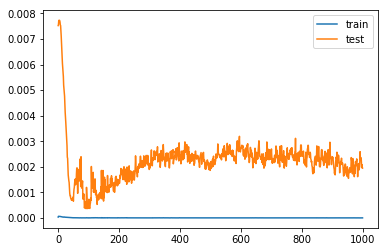

In [24]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)

In [26]:
model.evaluate(test_X, test_y, verbose=1)

709/709 [==============================] - 0s 71us/sample - loss: 0.0019


0.0019466552538327658

In [130]:
test_y

array([[0.02663536],
       [0.03109382],
       [0.0277146 ],
       [0.02575551],
       [0.02892586],
       [0.06071634],
       [0.06523206],
       [0.05198823],
       [0.04795792],
       [0.04822139],
       [0.0474396 ],
       [0.04886055],
       [0.041931  ],
       [0.04416054],
       [0.04715524],
       [0.03894806],
       [0.03082206],
       [0.02959305],
       [0.03500162],
       [0.03308832],
       [0.03542424],
       [0.03775501],
       [0.03924733],
       [0.03750757],
       [0.03910944],
       [0.04158773],
       [0.04519404],
       [0.04855829],
       [0.04366389],
       [0.04788607],
       [0.03734124],
       [0.03651129],
       [0.03911983],
       [0.03952863],
       [0.03896037],
       [0.04170977],
       [0.05332447],
       [0.05003922],
       [0.04217811],
       [0.04482324],
       [0.05134599],
       [0.04363631],
       [0.04780782],
       [0.05531641],
       [0.08223581],
       [0.07911801],
       [0.08169475],
       [0.091

In [77]:
yhat.shape

(709, 1, 1)

In [27]:
yhat = yhat.reshape(709,1)
feat_cols = -1 * (n_features - 1)

In [28]:
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))

In [29]:
#inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)

In [30]:
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

In [31]:
from math import sqrt

In [32]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, feat_cols:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [33]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, feat_cols:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2679.445


In [34]:
inv_yhat.shape

(709,)

In [35]:
inv_y

array([ 1795.6571,  2066.4175,  1861.1989,  1742.2242,  1934.7582,
        3865.3806,  4139.618 ,  3335.3262,  3090.5674,  3106.5679,
        3059.09  ,  3145.3835,  2724.555 ,  2859.954 ,  3041.8208,
        2543.4023,  2049.914 ,  1975.2762,  2303.7366,  2187.5427,
        2329.4023,  2470.9487,  2561.5767,  2455.9216,  2553.2026,
        2703.7085,  2922.718 ,  3127.0276,  2829.7925,  3086.2036,
        2445.821 ,  2395.418 ,  2553.8335,  2578.66  ,  2544.1501,
        2711.1194,  3416.4753,  3216.9634,  2739.5618,  2900.1995,
        3296.3235,  2828.118 ,  3081.4514,  3537.445 ,  5172.2485,
        4982.906 ,  5139.3906,  5719.7197,  5081.672 ,  5916.246 ,
        5379.735 ,  3872.1704,  4659.168 ,  4302.881 ,  4525.0337,
        4454.4736,  4409.074 ,  4662.0586,  4028.3416,  4793.367 ,
        5013.4478,  4369.243 ,  4238.87  ,  5237.824 ,  4566.207 ,
        4068.398 ,  3683.8936,  3984.6836,  4435.4844,  3942.5337,
        3546.9163,  3489.2622,  3036.1292,  3051.3572,  3411.0

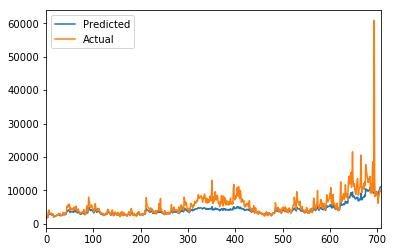

In [36]:
results = {'Predicted':inv_yhat ,'Actual':inv_y}
df_results = pd.DataFrame(results)
df_results.plot()

In [128]:
df_results.tail()

,Predicted,Actual
704,9668.303711,8586.253906
705,10131.058594,8986.800781
706,11238.930664,10091.359375
707,11200.669922,10000.820312
708,11005.794922,9813.525391


In [129]:
model.save_weights("day_model.h5")